In [16]:
using CSV, DataFrames
using Gurobi, JuMP

# df = CSV.File("JSSPlvl3 - 20.csv") |> DataFrame
# # Initialize dictionaries
# LL = Dict()
# GG = Dict()
# MG = Dict()
# nk = Dict()
# Nk = Dict()
# TIK = Dict()
# JobMachine = Dict()
# JobMachine1 = Dict()
# JobMachine2 = Dict()
# JO = []

# # Parse the DataFrame
# for row in eachrow(df)
#     job_id = row["Job ID"]
#     group_id = row["Group ID"]
#     operation_id = row["Operation ID"]
#     machine_ids = split(row["Machine ID"], " or ")
#     times = split(row["Time (s)"], " or ")

#     # Populate LL, GG, JO
#     push!(get!(LL, job_id, []), operation_id)
#     push!(get!(GG, job_id, []), group_id)
#     push!(JO, (job_id, operation_id))

#     # Populate MG, nk
#     for mid in machine_ids
#         m = parse(Int, mid)
#         push!(get!(MG, (job_id, group_id), []), m)
#         nk[m] = get(nk, m, 0) + 1
#     end

#     # Populate Nk
#     for (i, mid) in enumerate(machine_ids)
#         m = parse(Int, mid)
#         push!(get!(Nk, m, []), (job_id, operation_id))
#         # Populate TIK
#         TIK[(job_id, operation_id, m)] = parse(Int, times[i])
#     end

#     # Populate JobMachine, JobMachine1, JobMachine2
#     push!(get!(JobMachine, job_id, []), machine_ids...)
#     if length(machine_ids) > 1
#         JobMachine1[job_id] = [parse(Int, machine_ids[1])]
#         JobMachine2[job_id] = [parse(Int, machine_ids[2])]
#     else
#         JobMachine1[job_id] = [parse(Int, machine_ids[1])]
#     end
# end

# # Remove duplicates and sort the lists in the dictionaries
# LL = Dict(job_id => sort(unique(ops)) for (job_id, ops) in LL)
# GG = Dict(job_id => sort(unique(groups)) for (job_id, groups) in GG)
# MG = Dict(k => unique(v) for (k, v) in MG)
# Nk = Dict(k => unique(v) for (k, v) in Nk)
# JobMachine = Dict(k => unique(v) for (k, v) in JobMachine)
# JobMachine1 = Dict(k => unique(v) for (k, v) in JobMachine1)
# JobMachine2 = Dict(k => unique(v) for (k, v) in JobMachine2)
# JO = unique(JO)

# # Calculate GCJ - group count for each job
# GCJ = Dict(job_id => length(groups) for (job_id, groups) in GG)

# # Determine the number of jobs (II) and the number of machines (MM)
# II = maximum(df[!, "Job ID"])
# MM = parse(Int, maximum(reduce(vcat, values(JobMachine))));

# # Initialize the dictionaries
# Nk = Dict()
# TIK = Dict()
# JobMachine = Dict()
# JobMachine1 = Dict()
# JobMachine2 = Dict((i, []) for i in 1:II)

# # Process the DataFrame
# for row in eachrow(df)
#     job_id = row["Job ID"]
#     operation_id = row["Operation ID"]
#     machine_id_str = row["Machine ID"]
#     time_str = row["Time (s)"]

#     # Split the machine IDs and times if they contain "or"
#     machine_ids = split(machine_id_str, " or ")
#     times = split(time_str, " or ")

#     # Assume the first machine and time are always directly assigned (no "or")
#     primary_machine = parse(Int, machine_ids[1])
#     primary_time = parse(Int, times[1])

#     # Populate the TIK dictionary for the primary machine
#     TIK[(job_id, primary_machine)] = primary_time

#     # Populate the JobMachine and JobMachine1 dictionaries
#     push!(get!(JobMachine, job_id, []), primary_machine)
#     if length(machine_ids) == 1
#         push!(get!(JobMachine1, job_id, []), primary_machine)
#     end

#     # Handle additional machines and times if present
#     if length(machine_ids) > 1
#         for i in 2:length(machine_ids)
#             secondary_machine = parse(Int, machine_ids[i])
#             secondary_time = parse(Int, times[i])
            
#             # Populate the TIK dictionary for the secondary machine
#             TIK[(job_id, secondary_machine)] = secondary_time
#         end
#         for i in 1:length(machine_ids)
#             secondary_machine = parse(Int, machine_ids[i])
#             # Populate the JobMachine and JobMachine2 dictionaries
#             idx = findfirst(==(secondary_machine), JobMachine1)
#             if idx !== nothing
#                 deleteat!(JobMachine1, idx)
#             end
#             push!(get!(JobMachine, job_id, []), secondary_machine)
#             push!(get!(JobMachine2, job_id, []), secondary_machine)
#         end
#     end

#     # Populate the Nk dictionary
#     for m_id in machine_ids
#         machine_id = parse(Int, m_id)
#         push!(get!(Nk, machine_id, []), job_id)
#     end
# end

# # Remove duplicates from the lists in the dictionaries
# JobMachine = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine)
# JobMachine1 = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine1)
# JobMachine2 = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine2)
# Nk = Dict(machine_id => unique(jobs) for (machine_id, jobs) in Nk);

In [20]:
using CSV, DataFrames

function process_job_shop_data(filename::String)
    df = CSV.File(filename) |> DataFrame

    # Initialize dictionaries
    LL, GG, MG, nk, Nk, TIK, JobMachine, JobMachine1, JobMachine2, JO = Dict(), Dict(), Dict(), Dict(), Dict(), Dict(), Dict(), Dict(), Dict(), []
    
    # Parse the DataFrame
    for row in eachrow(df)
        job_id = row["Job ID"]
        group_id = row["Group ID"]
        operation_id = row["Operation ID"]
        machine_ids = split(row["Machine ID"], " or ")
        times = split(row["Time (s)"], " or ")
    
        # Populate LL, GG, JO
        push!(get!(LL, job_id, []), operation_id)
        push!(get!(GG, job_id, []), group_id)
        push!(JO, (job_id, operation_id))
    
        # Populate MG, nk
        for mid in machine_ids
            m = parse(Int, mid)
            push!(get!(MG, (job_id, group_id), []), m)
            nk[m] = get(nk, m, 0) + 1
        end
    
        # Populate Nk
        for (i, mid) in enumerate(machine_ids)
            m = parse(Int, mid)
            push!(get!(Nk, m, []), (job_id, operation_id))
            # Populate TIK
            TIK[(job_id, operation_id, m)] = parse(Int, times[i])
        end
    
        # Populate JobMachine, JobMachine1, JobMachine2
        push!(get!(JobMachine, job_id, []), machine_ids...)
        if length(machine_ids) > 1
            JobMachine1[job_id] = [parse(Int, machine_ids[1])]
            JobMachine2[job_id] = [parse(Int, machine_ids[2])]
        else
            JobMachine1[job_id] = [parse(Int, machine_ids[1])]
        end
    end
    
    # Remove duplicates and sort the lists in the dictionaries
    LL = Dict(job_id => sort(unique(ops)) for (job_id, ops) in LL)
    GG = Dict(job_id => sort(unique(groups)) for (job_id, groups) in GG)
    MG = Dict(k => unique(v) for (k, v) in MG)
    Nk = Dict(k => unique(v) for (k, v) in Nk)
    JobMachine = Dict(k => unique(v) for (k, v) in JobMachine)
    JobMachine1 = Dict(k => unique(v) for (k, v) in JobMachine1)
    JobMachine2 = Dict(k => unique(v) for (k, v) in JobMachine2)
    JO = unique(JO)
    
    # Calculate GCJ - group count for each job
    GCJ = Dict(job_id => length(groups) for (job_id, groups) in GG)
    
    # Determine the number of jobs (II) and the number of machines (MM)
    II = maximum(df[!, "Job ID"])
    MM = parse(Int, maximum(reduce(vcat, values(JobMachine))));
    
    # Initialize the dictionaries
    Nk = Dict()
    TIK = Dict()
    JobMachine = Dict()
    JobMachine1 = Dict()
    JobMachine2 = Dict((i, []) for i in 1:II)
    
    # Process the DataFrame
    for row in eachrow(df)
        job_id = row["Job ID"]
        operation_id = row["Operation ID"]
        machine_id_str = row["Machine ID"]
        time_str = row["Time (s)"]
    
        # Split the machine IDs and times if they contain "or"
        machine_ids = split(machine_id_str, " or ")
        times = split(time_str, " or ")
    
        # Assume the first machine and time are always directly assigned (no "or")
        primary_machine = parse(Int, machine_ids[1])
        primary_time = parse(Int, times[1])
    
        # Populate the TIK dictionary for the primary machine
        TIK[(job_id, primary_machine)] = primary_time
    
        # Populate the JobMachine and JobMachine1 dictionaries
        push!(get!(JobMachine, job_id, []), primary_machine)
        if length(machine_ids) == 1
            push!(get!(JobMachine1, job_id, []), primary_machine)
        end
    
        # Handle additional machines and times if present
        if length(machine_ids) > 1
            for i in 2:length(machine_ids)
                secondary_machine = parse(Int, machine_ids[i])
                secondary_time = parse(Int, times[i])
                
                # Populate the TIK dictionary for the secondary machine
                TIK[(job_id, secondary_machine)] = secondary_time
            end
            for i in 1:length(machine_ids)
                secondary_machine = parse(Int, machine_ids[i])
                # Populate the JobMachine and JobMachine2 dictionaries
                idx = findfirst(==(secondary_machine), JobMachine1)
                if idx !== nothing
                    deleteat!(JobMachine1, idx)
                end
                push!(get!(JobMachine, job_id, []), secondary_machine)
                push!(get!(JobMachine2, job_id, []), secondary_machine)
            end
        end
    
        # Populate the Nk dictionary
        for m_id in machine_ids
            machine_id = parse(Int, m_id)
            push!(get!(Nk, machine_id, []), job_id)
        end
    end
    
    # Remove duplicates from the lists in the dictionaries
    JobMachine = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine)
    JobMachine1 = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine1)
    JobMachine2 = Dict(job_id => unique(machines) for (job_id, machines) in JobMachine2)
    Nk = Dict(machine_id => unique(jobs) for (machine_id, jobs) in Nk);

    return LL, GG, MG, nk, Nk, TIK, JobMachine, JobMachine1, JobMachine2, JO, GCJ, II, MM
end

# Example usage
filename = "JSSPlvl3 - 20.csv"
LL, GG, MG, nk, Nk, TIK, JobMachine, JobMachine1, JobMachine2, JO, GCJ, II, MM = process_job_shop_data(filename);

In [13]:
model = Model(Gurobi.Optimizer)

# Decision Variables - Sparse definition using a dictionary
validx = [ (i, j, k) for i in 1:II for k in JobMachine[i] for j in 1:nk[k] ]
@variable(model, x[validx], Bin)
@variable(model, h[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
@variable(model, s[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
@variable(model, s0[ k in 1:MM ] >= 0, Int)
@variable(model, TX[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
valid_deltas = []
for (group, machines) in MG
    for a in 1:length(machines)
        for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
            for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                push!( valid_deltas, (group[1], group[2], machines[a], machines[b], jj, jjj) )
            end
        end
    end
end
@variable(model, delta[ valid_deltas ], Bin);
@variable(model, h_star >= 0, Int);

# Objective: Minimize the maximum completion time
@objective(model, Min, h_star);

# Constraint Set 1: Each job is processed a specific number of times
for i in 1:II
    for k in JobMachine1[i]
        @constraint(model, sum(x[(i, j, k)] for j in 1:nk[k]) == 1)
    if length(JobMachine2[i]) > 0
        k1 = JobMachine2[i][1]
        k2 = JobMachine2[i][2]
        @constraint(model, sum(x[(i, j, k1)] for j in 1:nk[k1]) + sum(x[(i, j, k2)] for j in 1:nk[k2]) == 1)
        end
    end
end

# Constraint Set 2: At most one operation at each order position on each machine
for k in 1:MM 
    for j in 1:nk[k]
        @constraint(model, sum(x[(i, j, k)] for i in Nk[k]) <= 1)
    end
end

# Constraint Set 3: Define the processing time for each order position on each machine
for k in 1:MM
    for j in 1:nk[k]
        @constraint(model, TX[(j, k)] == sum( get(TIK, (i, k), 0) * x[(i, j, k)] for i in Nk[k] ))
    end
end
for k in 1:MM
    @constraint(model, h[(1, k)] == s0[k])
end
for k in 1:MM
    for j in 2:nk[k]
        @constraint(model, h[(j, k)] == sum( TX[(q, k)] for q in 1:j-1 ) + sum( s[(q, k)] for q in 1:j-1 ) + s0[k])
    end
end

# Constraint Set 4: Precedence constraints
M = 2000
for i in 1:II
    for g1 in 2:GCJ[i]
        g = g1 - 1
        # g and g1 are group id of job i: g & g+1
        for a in MG[(i, g)]
            for b in MG[(i, g1)]
                # println("job ", i, " machine a ", a, " machine b ", b)
                for jj in 1:nk[a]
                    for jjj in 1:nk[b]
                        @constraint(
                            model, 
                            h[(jj, a)] + get(TIK, (i, a), 0) * x[(i, jj, a)] <= h[(jjj, b)] + M * (1 - x[(i, jj, a)]) + M * (1 - x[(i, jjj, b)])
                        )
                    end
                end
            end
        end
    end
end

# # Constraint Set 5: No overlap within the same machine group
# for (group, machines) in MG
#     for a in 1:length(machines)
#         for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
#             for jj in 1:nk[machines[a]]
#                 for jjj in 1:nk[machines[b]]
#                     i = group[1]
#                     ma = machines[a]
#                     mb = machines[b]
#                     @constraint(
#                         model, 
#                         h[(jj, ma)] + get(TIK, (i, ma), 0) * x[(i, jj, ma)] <= h[(jjj, mb)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
#                         + 3 * M * delta[(i, group[2], ma, mb, jj, jjj)]
#                     )
#                     @constraint(
#                         model, 
#                         h[(jjj, mb)] + get(TIK, (i, mb), 0) * x[(i, jjj, mb)] <= h[(jj, ma)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
#                         + 3 * M * (1 - delta[(i, group[2], ma, mb, jj, jjj)])
#                     )
#                 end
#             end
#         end
#     end
# end

# Constraint Set 6: h_star is greater than or equal to the end time of the last operation on each machine
for k in 1:MM
    @constraint(model, h_star >= h[(nk[k], k)] + TX[(nk[k], k)])
end

# Constraint Set 7: order pos
for k in 1:MM 
    for j in 2:nk[k]
        jprev = j - 1
        @constraint(model, sum(x[(i, jprev, k)] for i in Nk[k]) >= sum(x[(i, j, k)] for i in Nk[k]))
    end
end

# Optimize 
set_time_limit_sec(model, 10.0) # run at most 10s
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15717 rows, 8140 columns and 70237 nonzeros
Model fingerprint: 0x31882145
Variable types: 0 continuous, 8140 integer (7868 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 95 rows and 6567 columns
Presolve time: 0.05s
Presolved: 15622 rows, 1573 columns, 66745 nonzeros
Variable types: 0 continuous, 1573 integer (1392 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.200000e+03, 843 iterations, 0.05 seconds (0.12 work units)

    Nodes    |    Current 

In [21]:
function build_optimization_model(filename::String, M=2000, time_limit=10.0)
    LL, GG, MG, nk, Nk, TIK, JobMachine, JobMachine1, JobMachine2, JO, GCJ, II, MM = process_job_shop_data(filename)
    
    model = Model(Gurobi.Optimizer)
    
    # Decision Variables - Sparse definition using a dictionary
    validx = [ (i, j, k) for i in 1:II for k in JobMachine[i] for j in 1:nk[k] ]
    @variable(model, x[validx], Bin)
    @variable(model, h[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    @variable(model, s[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    @variable(model, s0[ k in 1:MM ] >= 0, Int)
    @variable(model, TX[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
    valid_deltas = []
    for (group, machines) in MG
        for a in 1:length(machines)
            for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
                for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                    push!( valid_deltas, (group[1], group[2], machines[a], machines[b], jj, jjj) )
                end
            end
        end
    end
    @variable(model, delta[ valid_deltas ], Bin);
    @variable(model, h_star >= 0, Int);
    
    # Objective: Minimize the maximum completion time
    @objective(model, Min, h_star);
    
    # Constraint Set 1: Each job is processed a specific number of times
    for i in 1:II
        for k in JobMachine1[i]
            @constraint(model, sum(x[(i, j, k)] for j in 1:nk[k]) == 1)
        if length(JobMachine2[i]) > 0
            k1 = JobMachine2[i][1]
            k2 = JobMachine2[i][2]
            @constraint(model, sum(x[(i, j, k1)] for j in 1:nk[k1]) + sum(x[(i, j, k2)] for j in 1:nk[k2]) == 1)
            end
        end
    end
    
    # Constraint Set 2: At most one operation at each order position on each machine
    for k in 1:MM 
        for j in 1:nk[k]
            @constraint(model, sum(x[(i, j, k)] for i in Nk[k]) <= 1)
        end
    end
    
    # Constraint Set 3: Define the processing time for each order position on each machine
    for k in 1:MM
        for j in 1:nk[k]
            @constraint(model, TX[(j, k)] == sum( get(TIK, (i, k), 0) * x[(i, j, k)] for i in Nk[k] ))
        end
    end
    for k in 1:MM
        @constraint(model, h[(1, k)] == s0[k])
    end
    for k in 1:MM
        for j in 2:nk[k]
            @constraint(model, h[(j, k)] == sum( TX[(q, k)] for q in 1:j-1 ) + sum( s[(q, k)] for q in 1:j-1 ) + s0[k])
        end
    end
    
    # Constraint Set 4: Precedence constraints
    M = 2000
    for i in 1:II
        for g1 in 2:GCJ[i]
            g = g1 - 1
            # g and g1 are group id of job i: g & g+1
            for a in MG[(i, g)]
                for b in MG[(i, g1)]
                    # println("job ", i, " machine a ", a, " machine b ", b)
                    for jj in 1:nk[a]
                        for jjj in 1:nk[b]
                            @constraint(
                                model, 
                                h[(jj, a)] + get(TIK, (i, a), 0) * x[(i, jj, a)] <= h[(jjj, b)] + M * (1 - x[(i, jj, a)]) + M * (1 - x[(i, jjj, b)])
                            )
                        end
                    end
                end
            end
        end
    end
    
    # # Constraint Set 5: No overlap within the same machine group
    # for (group, machines) in MG
    #     for a in 1:length(machines)
    #         for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
    #             for jj in 1:nk[machines[a]]
    #                 for jjj in 1:nk[machines[b]]
    #                     i = group[1]
    #                     ma = machines[a]
    #                     mb = machines[b]
    #                     @constraint(
    #                         model, 
    #                         h[(jj, ma)] + get(TIK, (i, ma), 0) * x[(i, jj, ma)] <= h[(jjj, mb)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
    #                         + 3 * M * delta[(i, group[2], ma, mb, jj, jjj)]
    #                     )
    #                     @constraint(
    #                         model, 
    #                         h[(jjj, mb)] + get(TIK, (i, mb), 0) * x[(i, jjj, mb)] <= h[(jj, ma)] + M * (1 - x[(i, jj, ma)]) + M * (1 - x[(i, jjj, mb)]) 
    #                         + 3 * M * (1 - delta[(i, group[2], ma, mb, jj, jjj)])
    #                     )
    #                 end
    #             end
    #         end
    #     end
    # end
    
    # Constraint Set 6: h_star is greater than or equal to the end time of the last operation on each machine
    for k in 1:MM
        @constraint(model, h_star >= h[(nk[k], k)] + TX[(nk[k], k)])
    end
    
    # Constraint Set 7: order pos
    for k in 1:MM 
        for j in 2:nk[k]
            jprev = j - 1
            @constraint(model, sum(x[(i, jprev, k)] for i in Nk[k]) >= sum(x[(i, j, k)] for i in Nk[k]))
        end
    end
    
    # Optimize 
    set_time_limit_sec(model, time_limit) # run at most 10s
    optimize!(model);

    return model
end

my_model = build_optimization_model("JSSPlvl3 - 20.csv")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15717 rows, 8140 columns and 70237 nonzeros
Model fingerprint: 0x31882145
Variable types: 0 continuous, 8140 integer (7868 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 95 rows and 6567 columns
Presolve time: 0.05s
Presolved: 15622 rows, 1573 columns, 66745 nonzeros
Variable types: 0 continuous, 1573 integer (1392 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.200000e+03, 843 iterations, 0.05 seconds (0.12 work units)

    Nodes    |    Current 

A JuMP Model
Minimization problem with:
Variables: 8140
Objective function type: VariableRef
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 277 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 88 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 15352 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 272 constraints
`VariableRef`-in-`MathOptInterface.Integer`: 272 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 7868 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: TX, delta, h, h_star, s, s0, x

In [14]:
x_result = Dict()
for idx in [ (i, j, k) for i in 1:II for k in JobMachine[i] for j in 1:nk[k] ]
    x_result[idx] = value.(x[idx])
end
h_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    h_result[idx] = value.(h[idx])
end
s_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    s_result[idx] = value.(s[idx])
end
s0_result = Dict()
for idx in 1:MM
    s0_result[idx] = value.(s0[idx])
end
TX_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    TX_result[idx] = value.(TX[idx])
end

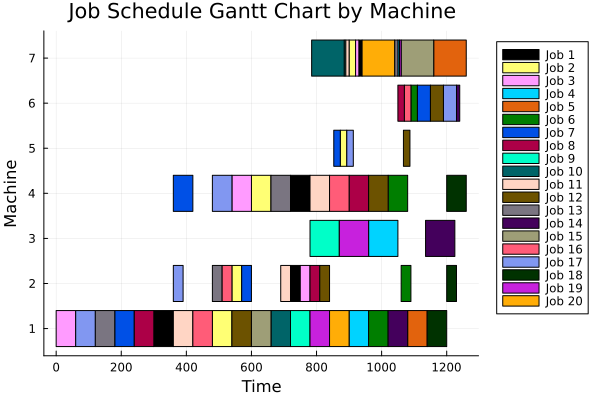

In [15]:
using Plots

# Function to plot Gantt chart with job legends
function plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, num_jobs)
    end_times = Dict()
    for (j, k) in keys(TX_result)
        end_times[(j, k)] = h_result[(j, k)] + TX_result[(j, k)]
    end
    
    gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

    # Generate a color for each job
    job_colors = distinguishable_colors(num_jobs)

    # Dictionary to keep track of which jobs have been plotted (to avoid duplicate legend entries)
    plotted_jobs = Dict()
    
    # Plot each task
    for k in 1:MM
        machine_schedule = []
        # Gather the tasks for this machine
        for i in 1:II
            for j in 1:nk[k]
                if get(x_result, (i, j, k), 0) > 0.1
                    push!(machine_schedule, (h_result[(j, k)], h_result[(j, k)] + TX_result[(j, k)], i))
                    break
                end
            end
        end
        for (start, finish, job_id) in machine_schedule
            color = job_colors[job_id]
            label = haskey(plotted_jobs, job_id) ? "" : "Job $job_id"  # Only label the first task of each job
            plotted_jobs[job_id] = true
            # plot!([start, finish], [k, k], bar=(150, color), label=label)
            shape = Shape([start, start, finish, finish], 
                      [k - 0.4, k + 0.4, k + 0.4, k - 0.4])
            plot!(shape, color=color, label=label)
        end
    end

    xlabel!("Time")
    ylabel!("Machine")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Calculate the end times for the tasks and populate h_result and TX_result accordingly

# Now let's create and display the Gantt chart with job legends
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II)
display(gantt_chart_with_job_legends)

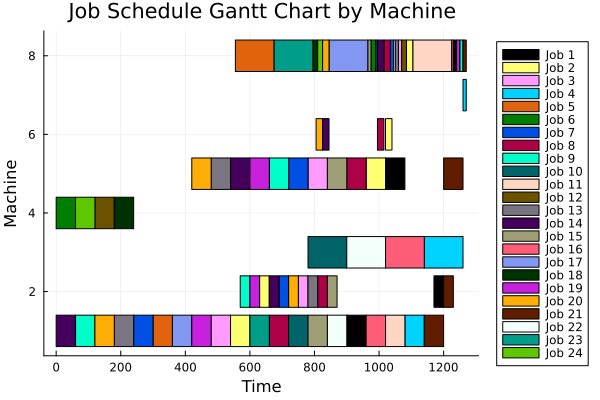

In [361]:
using Plots

function plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, num_jobs)
    gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

    # Generate a color for each job
    job_colors = distinguishable_colors(num_jobs)

    # Dictionary to keep track of which jobs have been plotted
    plotted_jobs = Dict()

    # Collect tasks by job for sorting and plotting
    tasks_by_job = Dict()
    for k in 1:MM
        for j in 1:nk[k]
            for i in 1:num_jobs
                if get(x_result, (i, j, k), 0) > 0.1
                    start_time = h_result[(j, k)]
                    end_time = start_time + TX_result[(j, k)]
                    push!(get!(tasks_by_job, i, []), (start_time, end_time, k))
                end
            end
        end
    end

    # Sort and plot tasks by job index
    for job_id in sort(collect(keys(tasks_by_job)))
        for (start, finish, k) in tasks_by_job[job_id]
            color = job_colors[job_id]
            label = get!(plotted_jobs, job_id, "Job $job_id")  # Only label the first task of each job
            plotted_jobs[job_id] = ""  # Subsequent tasks will have no label
            shape = Shape([start, start, finish, finish], [k - 0.4, k + 0.4, k + 0.4, k - 0.4])
            plot!(shape, color=color, label=label)
        end
    end

    xlabel!("Time")
    ylabel!("Machine")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Define h_result, TX_result, x_result, nk, MM, II with actual values

# Now let's create and display the Gantt chart with job legends
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II)
display(gantt_chart_with_job_legends)